In [1]:
import matplotlib.pyplot as plt

In [2]:
# If you have latex installed (For nice latex rendering)
plt.rcParams['text.usetex'] = True
plt.rcParams['text.latex.preamble'] = r'\usepackage{amsfonts}'

In [3]:
import torch
from gm_utils import geodesic

theta1 = torch.tensor([0.35, -2.3]) #(theta=(t, x))
theta2 = torch.tensor([0.4, 2])

num_discretization_points = 128
num_optimization_steps = 1000

shortest_path12 = geodesic(theta1, theta2, num_optimization_steps, num_discretization_points)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 350.13it/s]


If the data distribution $p_0$ is a Gaussian Mixture, then the denoising distribution $p(x_0\mid x_t)$ is also a Gaussian mixture.

Specifically, if $p_0 = \sum_i \pi_i \mathcal{N}(\mu_i, \sigma^2I)$, and $p_{t|0}(x_t\mid x_0) = \mathcal{N}(x_t\mid \alpha_tx_0, \sigma_t^2I)$, then

$$p_{0|t}(x_0\mid x_t) = \frac{p_0(x_0)p_{t|0}(x_t\mid x_0)}{p_t(x_t)} = \sum_i \pi_i \mathcal{N}(x_0\mid\tilde{\mu}_i, \tilde{\sigma}_t^2I),$$
where
\begin{align}
\tilde{\sigma}_t^2 &= \left( \frac{1}{\sigma^2} + \frac{\alpha_t^2}{\sigma_t^2} \right)^{-1} \\
\tilde{\mu}_i & = \tilde{\sigma}_t^2 \left( \frac{\mu_i}{\sigma^2} + \frac{\alpha_t^2}{\sigma_t^2}x_t  \right)
\end{align}

In [4]:
from gm_utils import get_means_and_variances # Implementation of the above means and variance for the denoising Gaussian mixture

In [5]:
import numpy as np
from gm_utils import visualize_density


def visualize_density_w_geodesic(ax):
    visualize_density(ax)
    ax.set_xlabel(r"$t$", labelpad=-12, fontsize=14)
    ax.set_yticks([])
    ax.set_xticks([0, 1], [r'$0$', r'$T$'], fontsize=14)
    ax.scatter(*theta1.numpy(), color='blue', s=5)
    ax.scatter(*theta2.numpy(), color='red', s=5)

    points = shortest_path12

    segments = np.concatenate([points[:-1, None], points[1:, None]], axis=1)
    norm = plt.Normalize(0, len(points) - 1)
    cmap = LinearSegmentedColormap.from_list('blue_red_gradient', ['blue', 'red'], N=len(points))

    lc = LineCollection(segments, cmap=cmap, norm=norm)
    lc.set_array(np.arange(len(points)))
    lc.set_linewidth(2)

    ax.add_collection(lc)
    ax.yaxis.set_label_position("right")
    ax.yaxis.tick_right()
    ax.set_ylabel(r"$\mathbf{x}$", fontsize=14)

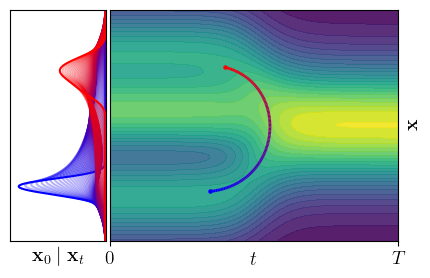

In [6]:
from matplotlib.collections import LineCollection
from matplotlib.colors import LinearSegmentedColormap
from scipy.stats import norm

from gm_utils import weights

fig, (ax2, ax1) = plt.subplots(ncols=2, figsize=(5, 3), width_ratios=[1, 3])

visualize_density_w_geodesic(ax1)

num_plots = num_discretization_points

cmap = LinearSegmentedColormap.from_list('blue_red_gradient', ['blue', 'red'], N=num_plots)
colors = [cmap(i / (num_plots - 1)) for i in range(num_plots)]

indices = np.round(np.linspace(0, num_plots - 1, num_plots)).astype(np.int32)
x = np.linspace(-6, 8, 1000)
max_pdf = 0

for idx in range(num_plots):
    theta = torch.from_numpy(shortest_path12[idx])
    mean, var = get_means_and_variances(theta[0], theta[1])
    pdf = np.zeros_like(x)
    for mean_i, weight_i in zip(mean, weights):
        pdf += weight_i.item() * norm.pdf(x, loc=mean_i, scale=var ** 0.5)
    pdf = pdf
    max_pdf = max(max_pdf, np.max(pdf))
    if idx == 0 or idx == num_plots - 1:
        alpha = 1
    else:
        alpha = 0.3
    ax2.plot(-pdf, x, color=colors[idx], alpha=alpha)
    ax2.set_ylim((-4, 4))
    ax2.set_xlim((-1.1 * max_pdf, 0))

ax2.set_xlabel(r'$\mathbf{x}_0 \mid \mathbf{x}_t$', fontsize=14)
ax2.set_xticks([])
ax2.set_yticks([])
plt.subplots_adjust(wspace=0.02)